https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py

In [ ]:
import json # For dealing with metadata
import os # For file level operations
import time # For timing demonstrations
import datetime # To demonstrate conversion between date and time formats
import glob
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import seaborn as sns

import sys
sys.path.append('/scratch/yichen/notebooks/helper_functions/')
from visualization_functions import show_images

def show_h5_dataset_name(ds_path, class_name):
    with h5py.File(ds_path) as hf:
        if class_name:
            print(hf[class_name].keys())            
        else:
            print(hf.keys())
            
def load_h5_examples(ds_path, class_name, ds_name, process_func=None, show=True):
    with h5py.File(ds_path) as hf:
        plumes = np.array(hf[class_name][ds_name])
    if show:
        if process_func:
            images = process_func(plumes)
        show_images(images, colorbar=True)
    return plumes

def get_metrics(plumes, image_process, show=True):
    
    metrics_name = ['area', 'area_filled', 'axis_major_length', 
                    'axis_minor_length', 'centroid-0', 'centroid-1', 'orientation', 
                    'eccentricity', 'perimeter']    
    metrics = {}
    for m in metrics_name:
        metrics[m] = []

    for i, images in enumerate(plumes):
        for m in metrics_name:
            metrics[m].append([])

        for img in images:
            img_show = image_process(img)
            if np.sum(img_show) == 0:
                for m in metrics_name:
                    metrics[m][i].append(0)
            else:
                props = regionprops_table(img_show, properties=([
                        'area', 'area_filled', 'axis_major_length', 
                        'axis_minor_length', 'centroid', 'orientation', 
                        'eccentricity', 'perimeter'
                                                                ]))
                data = pd.DataFrame(props)
                for m in metrics_name:
                    metrics[m][i].append(data[m][0])
                    
    plots_mean = []
    plots_all = []
    for n in metrics_name:
        y_plot = np.stack(metrics[n])
        plots_all.append(y_plot)
        plots_mean.append(np.mean(y_plot, axis=0))
        if show:
            h = plt.plot(np.mean(y_plot, axis=0), label=n)  
    if show:
        leg = plt.legend(loc='upper right')
        plt.show()
    
    plots_all = np.stack(plots_all)
    plots_mean = np.stack(plots_mean)
    return plots_mean, plots_all

def process_func(images):
    images = images[np.random.randint(0, images.shape[0])]
    return images

def image_process(img):
    img_show = np.copy(img)[:,50:]
    img_show[img_show<200]=0
    img_show[img_show>200]=200
    return img_show

def calculate_speed(plumes):
    velocity_all = []
    for plume in plumes:
        start = []
        for i, img in enumerate(plume):
            s = []
            for x in range(img.shape[1]):
                s.append(np.mean(img[:,x]))
            s = np.array(s)
            target_indices = np.where(s>100)
            
            if target_indices[0].size > 0:
                p = np.max(target_indices)
                start.append(p)
            elif i>0:
                start.append(start[i-1])
            else:
                start.append(0)  
                
        velocity_all.append(np.stack(start))
        
    velocity_all = np.stack(velocity_all, axis=0)
    velocity_mean = np.mean(velocity_all, axis=0)
    return velocity_mean, velocity_all

def convert_df(plots_all, condition):
    metrics_name = ['area', 'area_filled', 'axis_major_length', 
                    'axis_minor_length', 'centroid-1', 'centroid-2', 'orientation', 
                    'eccentricity', 'perimeter', 'velocity']  
    metric_name_index = np.repeat(metrics_name, plots_all.shape[1]*plots_all.shape[2])
    growth_index = np.repeat(np.arange(plots_all.shape[1]), plots_all.shape[0]*plots_all.shape[2])
    time_index = np.array(list(np.arange(plots_all.shape[2]))*plots_all.shape[1]*plots_all.shape[0])
    condition_list = [condition]*len(time_index)
    
    data = np.stack((condition_list, metric_name_index, growth_index, 
                     time_index, plots_all.reshape(-1)))

    df = pd.DataFrame( data=data.T, 
                       columns=['condition', 'metric', 'growth_index', 
                                'time_step', 'a.u.'] )
    
#     df['condition'] = df['condition'].astype(np.string)
#     df['metric'] = df['metric'].astype(np.string)
    df['growth_index'] = df['growth_index'].astype(np.int32)
    df['time_step'] = df['time_step'].astype(np.int32)
    df['a.u.'] = df['a.u.'].astype(np.float32)
    return df

In [2]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, img_per_row=8, colorbar=False):
    h = images[0].shape[1] // images[0].shape[0]*0.5 + 1
    if not labels:
        labels = range(len(images))
    fig, axes = plt.subplots(len(images)//img_per_row+1*int(len(images)%img_per_row>0), img_per_row, 
                             figsize=(16, h*len(images)//img_per_row+1))
    for i in range(len(images)):
        if len(images) <= img_per_row:
            axes[i%img_per_row].title.set_text(labels[i])
            im = axes[i%img_per_row].imshow(images[i])
            if colorbar:
                fig.colorbar(im, ax=axes[i%img_per_row])
            axes[i//img_per_row, i%img_per_row].axis('off')

        else:
            axes[i//img_per_row, i%img_per_row].title.set_text(labels[i])
            im = axes[i//img_per_row, i%img_per_row].imshow(images[i])
            if colorbar:
                fig.colorbar(im, ax=axes[i//img_per_row, i%img_per_row])
            axes[i//img_per_row, i%img_per_row].axis('off')
            
    plt.show()

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre']>


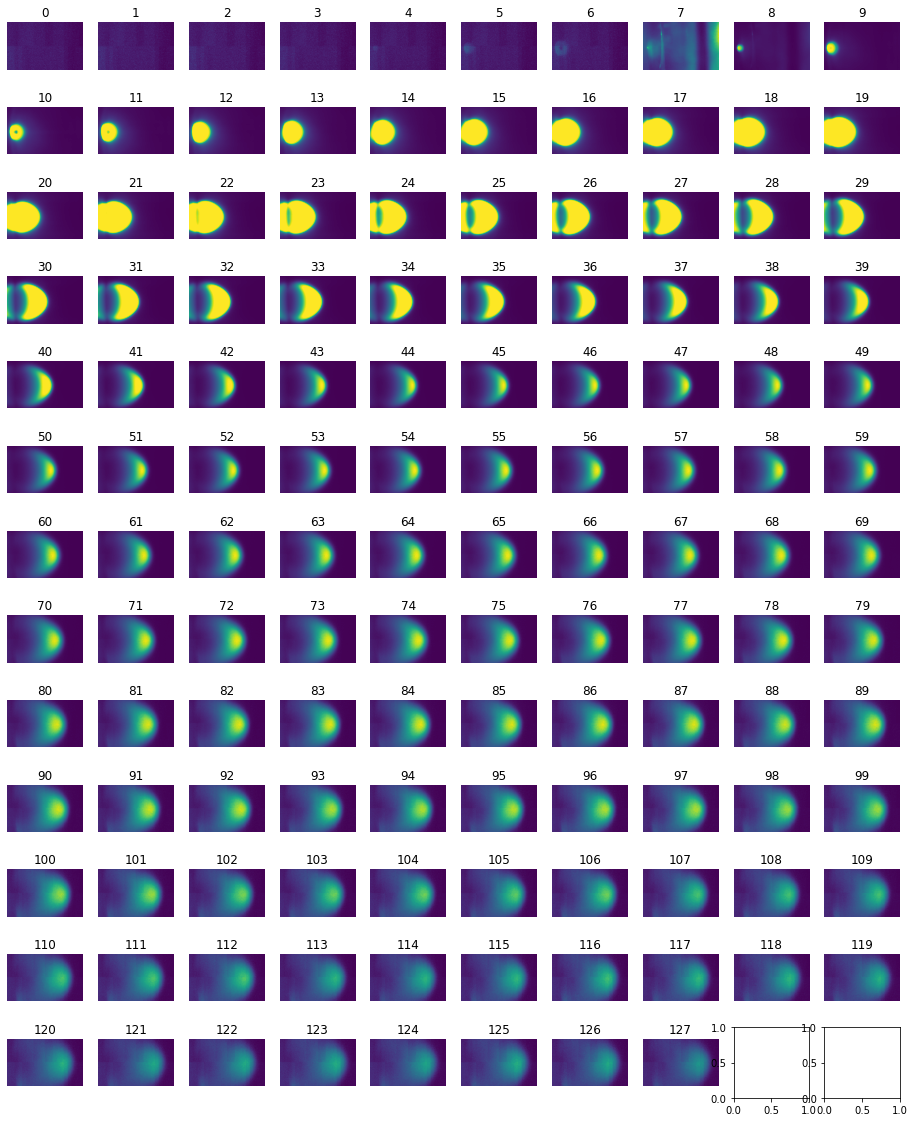

In [3]:
ds_path = '/scratch/yichen/pld_plumes/YG004_Yichen_Guo_04052022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0), img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3']>


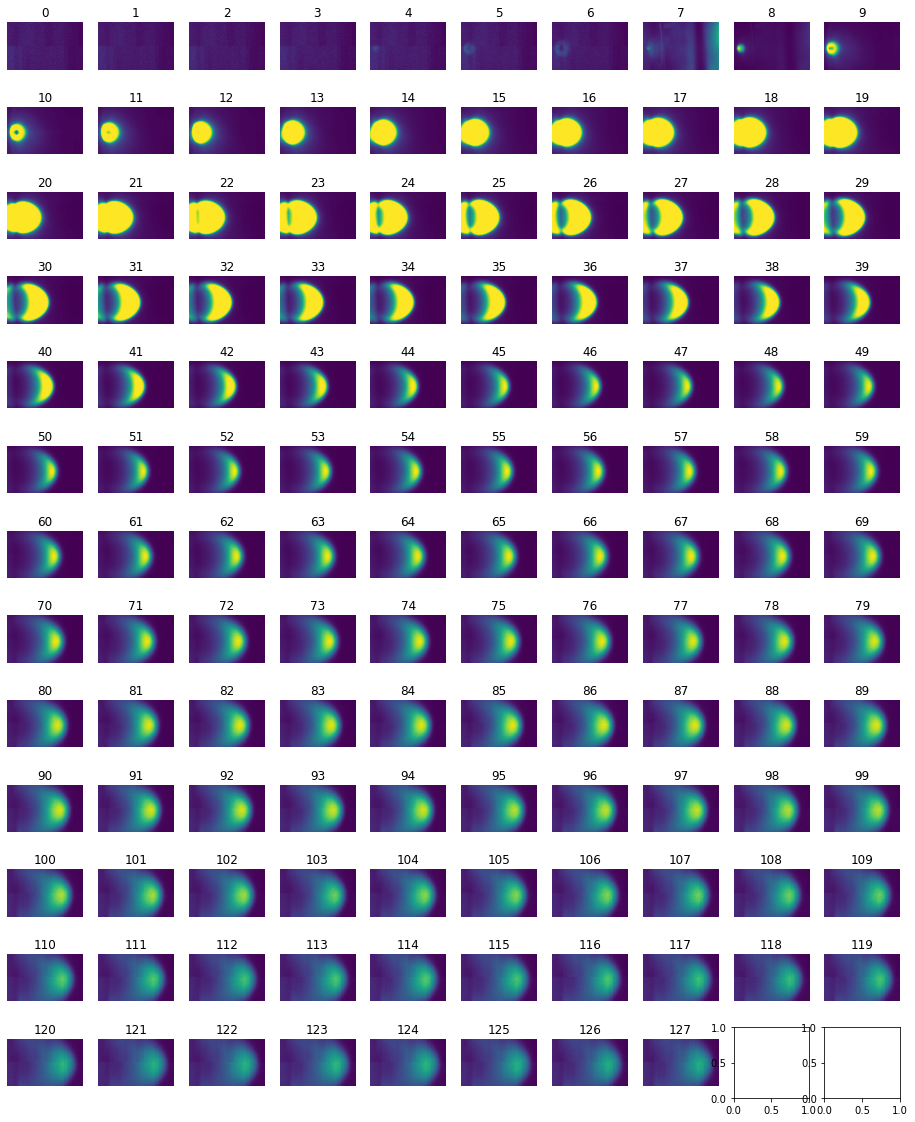

In [4]:
ds_path = '/scratch/yichen/pld_plumes/YG005_Yichen_Guo_04062022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0), img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


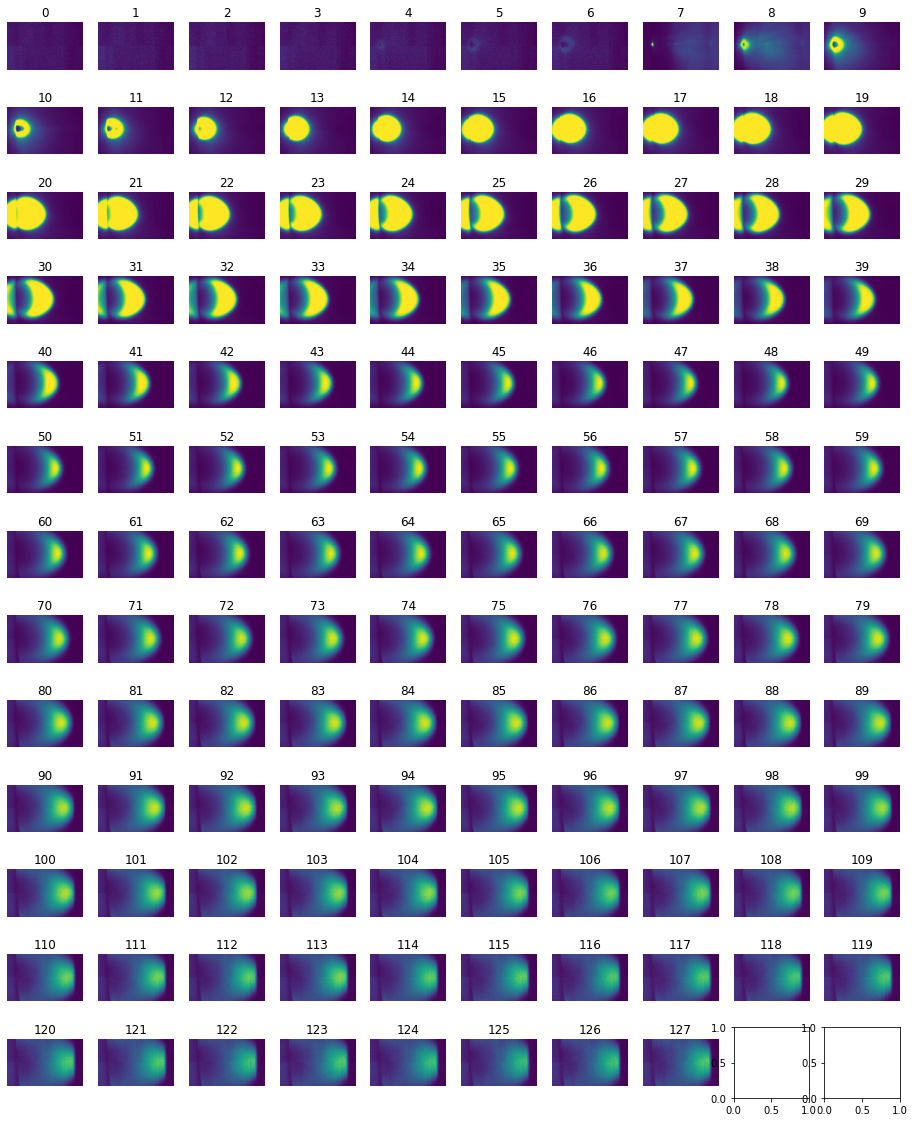

In [7]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0), img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3(Berkeley)', '0-SrRuO3(Berkeley)_Pre']>


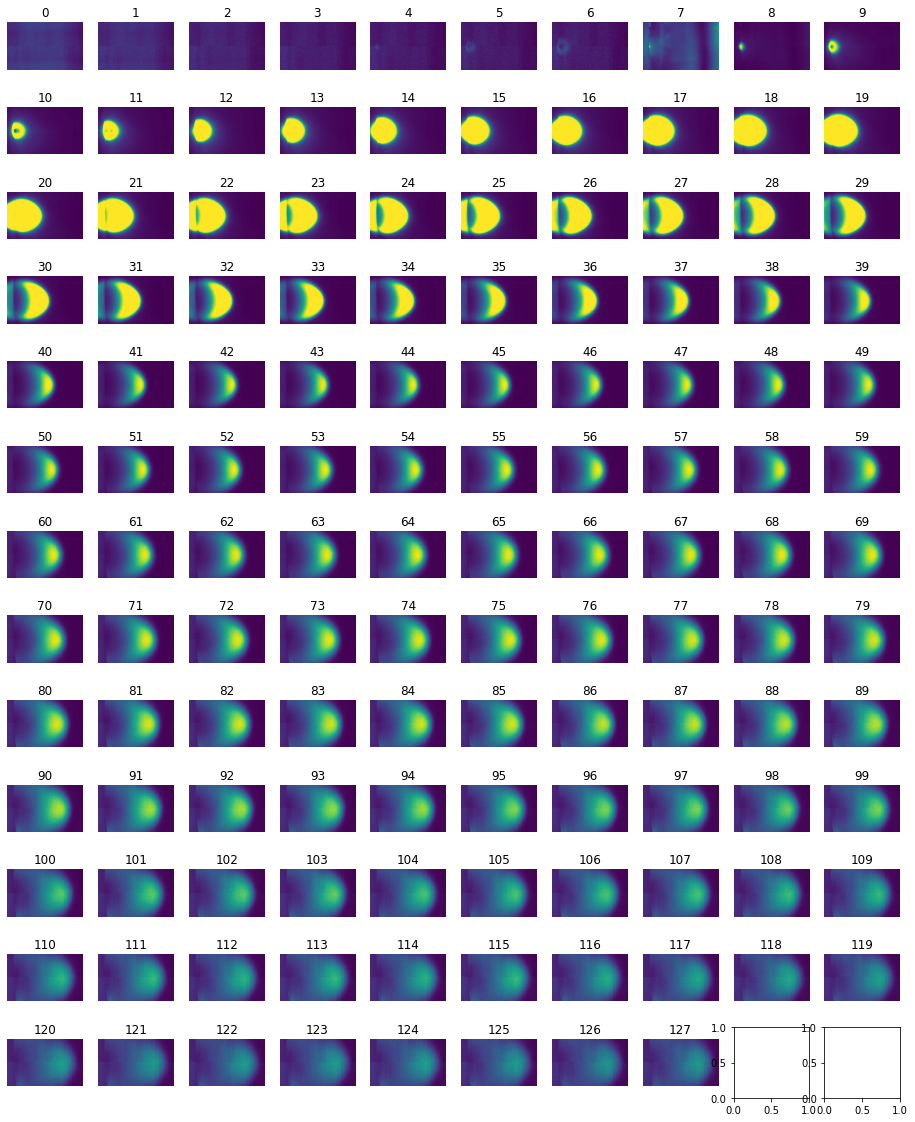

In [6]:
ds_path = '/scratch/yichen/pld_plumes/YG007_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3(Berkeley)'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0), img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


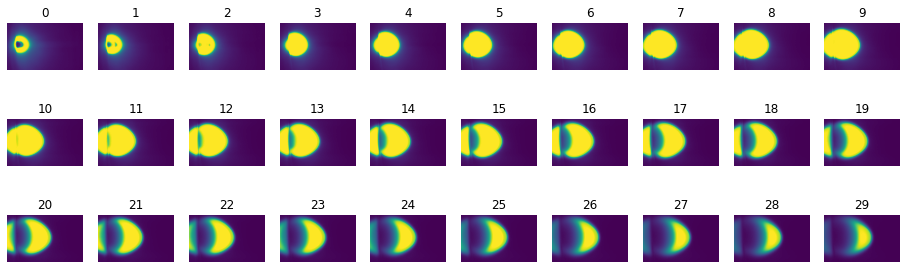

In [11]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '3-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


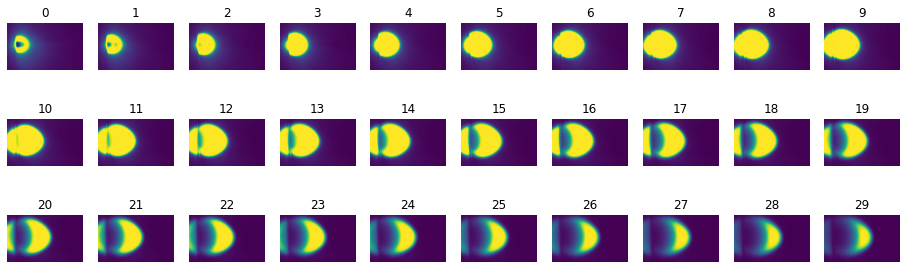

In [12]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '4-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


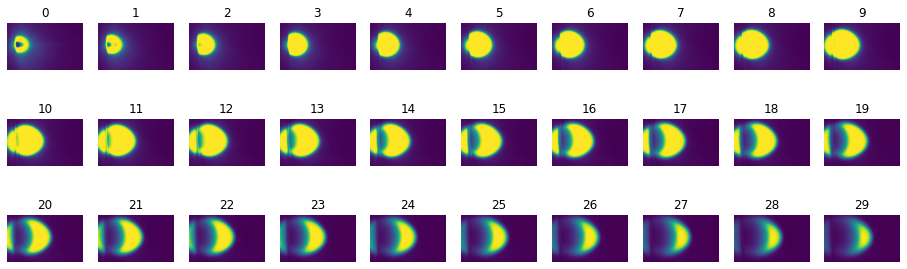

In [13]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '5-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


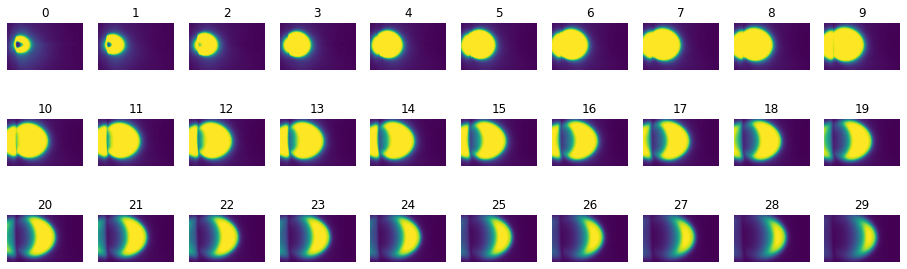

In [17]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '1-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


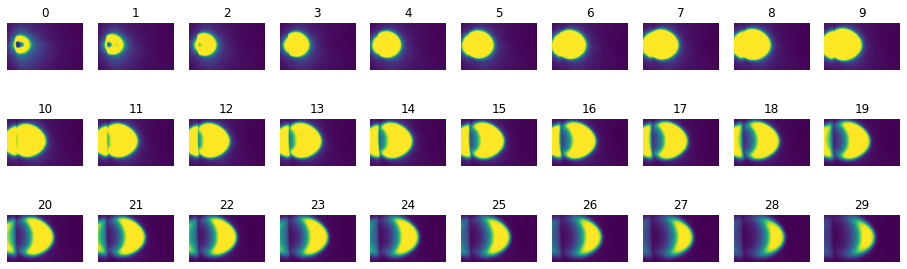

In [18]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>


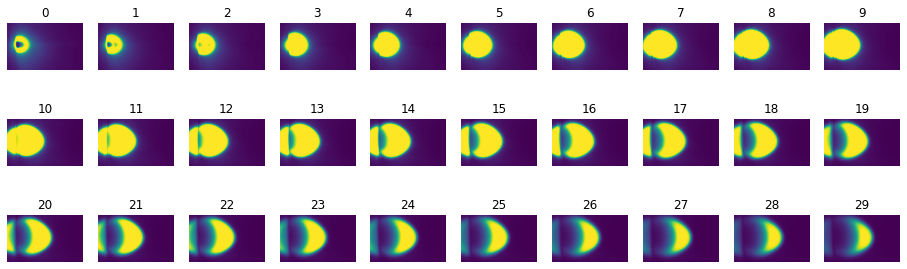

In [16]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'
class_name = 'PLD_Plumes'
ds_name = '2-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


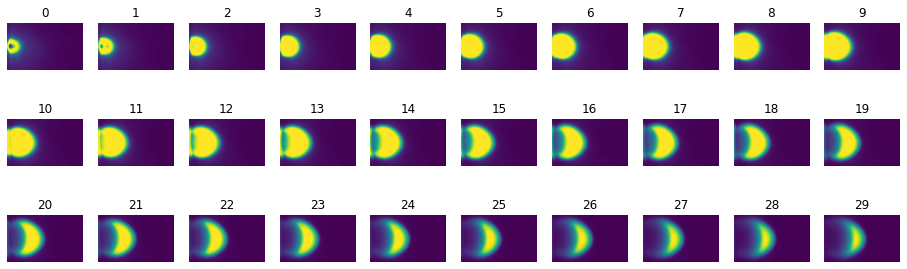

In [19]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '1-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


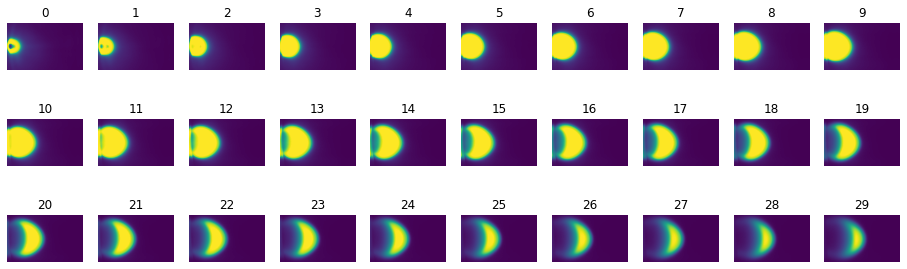

In [20]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '2-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


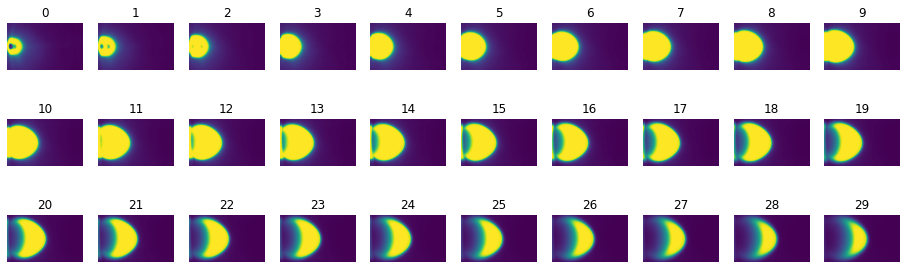

In [21]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '0-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


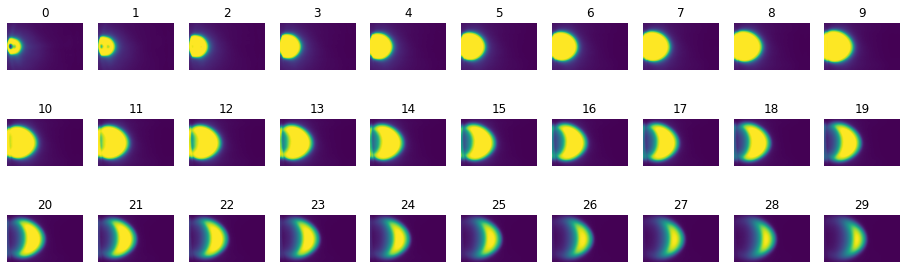

In [22]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '3-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


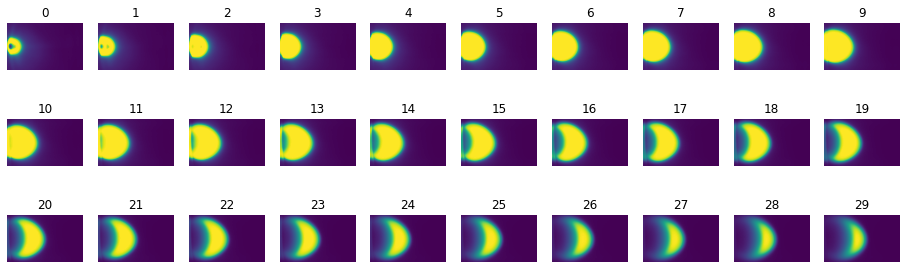

In [23]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'
class_name = 'PLD_Plumes'
ds_name = '4-SrRuO3'
show_h5_dataset_name(ds_path, class_name)
plumes = load_h5_examples(ds_path, class_name, ds_name, process_func, show=False)
show_images(np.mean(plumes, axis=0)[10:40], img_per_row=10)

In [5]:
def plumes_to_df(ds_path, ds_name, condition, show_plume=False):
    plumes = load_h5_examples(ds_path, 'PLD_Plumes', ds_name, process_func, show=False)
    if show_plume:
        show_images(np.mean(plumes, axis=0))

    plots_mean, plots_all = get_metrics(plumes, image_process, show=False)
    velocity_mean, velocity_all = calculate_speed(plumes)

    plots_mean = np.concatenate((plots_mean, velocity_mean.reshape(1, -1)))
    plots_all = np.concatenate((plots_all, velocity_all.reshape(1, velocity_all.shape[0], velocity_all.shape[1])))

    df = convert_df(plots_all, condition)
    return df

In [6]:
ds_path = '/scratch/yichen/pld_plumes/YG004_Yichen_Guo_04052022.h5'
ds_name = '0-SrRuO3'
condition='100mj-700c-200mtorr-berkeley_target'

df = plumes_to_df(ds_path, ds_name, condition)

In [7]:
df

condition    metric  growth_index  time_step  \
0      100mj-700c-200mtorr-berkeley_target      area             0          0   
1      100mj-700c-200mtorr-berkeley_target      area             0          1   
2      100mj-700c-200mtorr-berkeley_target      area             0          2   
3      100mj-700c-200mtorr-berkeley_target      area             0          3   
4      100mj-700c-200mtorr-berkeley_target      area             0          4   
...                                    ...       ...           ...        ...   
40955  100mj-700c-200mtorr-berkeley_target  velocity            31        123   
40956  100mj-700c-200mtorr-berkeley_target  velocity            31        124   
40957  100mj-700c-200mtorr-berkeley_target  velocity            31        125   
40958  100mj-700c-200mtorr-berkeley_target  velocity            31        126   
40959  100mj-700c-200mtorr-berkeley_target  velocity            31        127   

        a.u.  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
40955  212.0  
40956  212.0  
40957  212.0  
40958  212.0  
40959  212.0  

[40960 rows x 5 columns]

# load plumes

In [11]:
for ds_path in glob.glob('/scratch/yichen/pld_plumes/YG00*'):
    print(ds_path)
    show_h5_dataset_name(ds_path, 'PLD_Plumes')    

/scratch/yichen/pld_plumes/YG007_Yichen_Guo_04172022.h5
<KeysViewHDF5 ['0-SrRuO3(Berkeley)', '0-SrRuO3(Berkeley)_Pre']>
/scratch/yichen/pld_plumes/YG004_Yichen_Guo_04052022.h5
<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre']>
/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5
<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3', '5-SrRuO3']>
/scratch/yichen/pld_plumes/YG005_Yichen_Guo_04062022.h5
<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3']>
/scratch/yichen/pld_plumes/YG003_Yichen_Guo_03202022.h5
<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre']>
/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5
<KeysViewHDF5 ['0-SrRuO3', '0-SrRuO3_Pre', '1-SrRuO3', '2-SrRuO3', '3-SrRuO3', '4-SrRuO3']>


In [14]:
ds_path = '/scratch/yichen/pld_plumes/YG004_Yichen_Guo_04052022.h5'
ds_name = '0-SrRuO3'
condition='100mj-700c-200mtorr-1c_target(yg004)'

df_yg004 = plumes_to_df(ds_path, ds_name, condition)

In [15]:
ds_path = '/scratch/yichen/pld_plumes/YG005_Yichen_Guo_04062022.h5'

ds_name = '0-SrRuO3'
condition = '100mj-700c-200mtorr(yg005)'
df_yg005_0 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '1-SrRuO3'
condition = '150mj-700c-200mtorr(yg005)'
df_yg005_1 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '2-SrRuO3'
condition = '175mj-700c-200mtorr(yg005)'
df_yg005_2 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '3-SrRuO3'
condition = '200mj-700c-200mtorr(yg005)'
df_yg005_3 = plumes_to_df(ds_path, ds_name, condition)

In [21]:
ds_path = '/scratch/yichen/pld_plumes/YG006_Yichen_Guo_04132022.h5'

ds_name = '0-SrRuO3'
condition = '100mj-700c-200mtorr(yg006)'
df_yg006_0 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '1-SrRuO3'
condition = '100mj-700c-140mtorr(yg006)'
df_yg006_1 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '2-SrRuO3'
condition = '100mj-700c-240mtorr(yg006)'
df_yg006_2 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '3-SrRuO3'
condition = '100mj-650c-250mtorr(yg006)'
df_yg006_3 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '4-SrRuO3'
condition = '100mj-750c-250mtorr(yg006_0)'
df_yg006_4 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '5-SrRuO3'
condition = '100mj-750c-250mtorr(yg006_1)'
df_yg006_5 = plumes_to_df(ds_path, ds_name, condition)

In [19]:
ds_path = '/scratch/yichen/pld_plumes/YG007_Yichen_Guo_04172022.h5'

ds_name = '0-SrRuO3(Berkeley)'
condition = '100mj-700c-200mtorr-1a_target(yg007)'
df_yg007 = plumes_to_df(ds_path, ds_name, condition)

In [20]:
ds_path = '/scratch/yichen/pld_plumes/YG008_Yichen_Guo_04172022.h5'

ds_name = '0-SrRuO3'
condition = '100mj-700c-200mtorr-f=140mm(yg008)'
df_yg008_0 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '1-SrRuO3'
condition = '100mj-700c-200mtorr-f=130mm(yg008)'
df_yg008_1 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '2-SrRuO3'
condition = '100mj-700c-200mtorr-f=135mm(yg008)'
df_yg008_2 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '3-SrRuO3'
condition = '100mj-700c-200mtorr-f=145mm(yg008)'
df_yg008_3 = plumes_to_df(ds_path, ds_name, condition)

ds_name = '4-SrRuO3'
condition = '100mj-700c-200mtorr-f=150mm(yg008)'
df_yg008_4 = plumes_to_df(ds_path, ds_name, condition)

https://seaborn.pydata.org/generated/seaborn.lineplot.html

# different target, substrate

In [23]:
df_t_s = pd.concat([df_yg004, df_yg005_0, df_yg006_0, 
                    df_yg007, df_yg008_0], ignore_index=True)

area


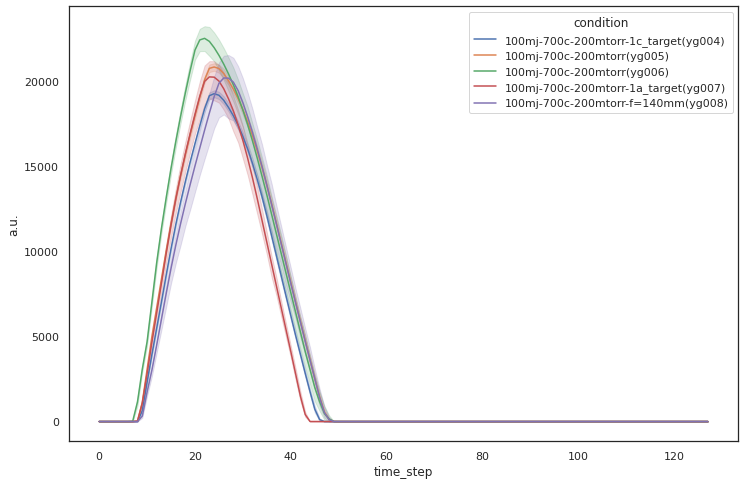

area_filled


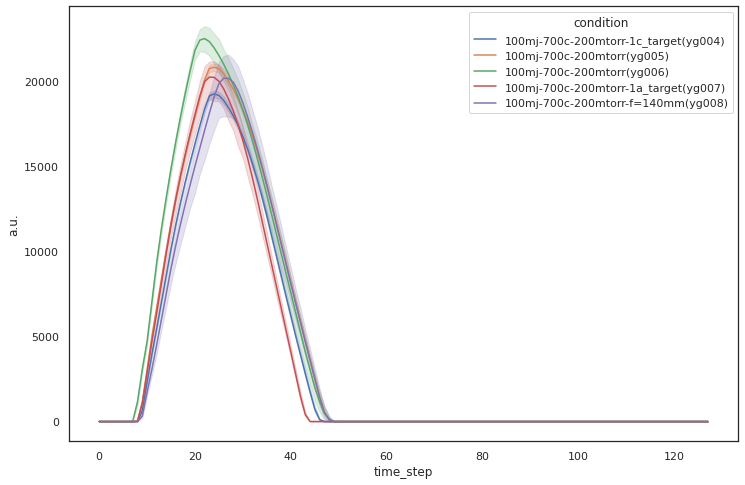

axis_major_length


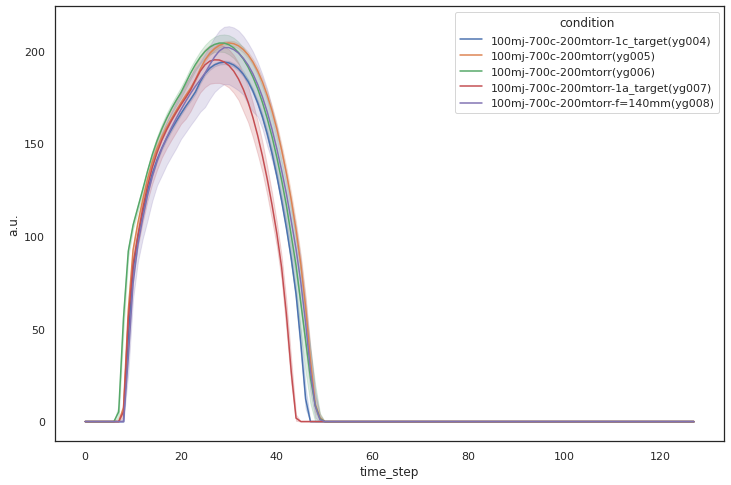

axis_minor_length


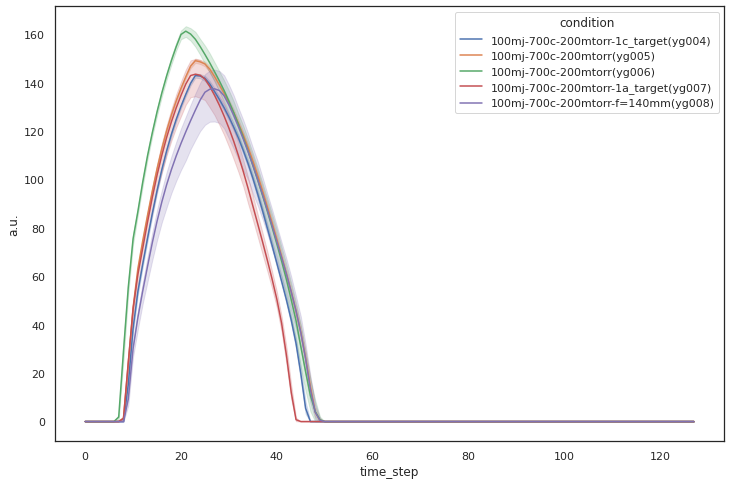

centroid-1


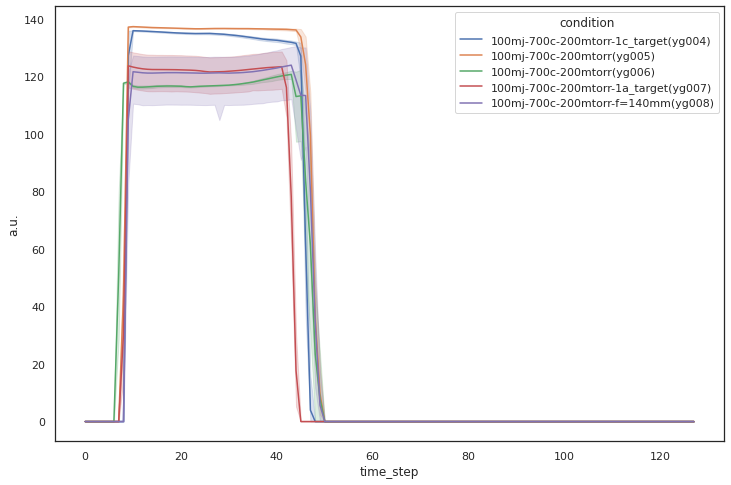

centroid-2


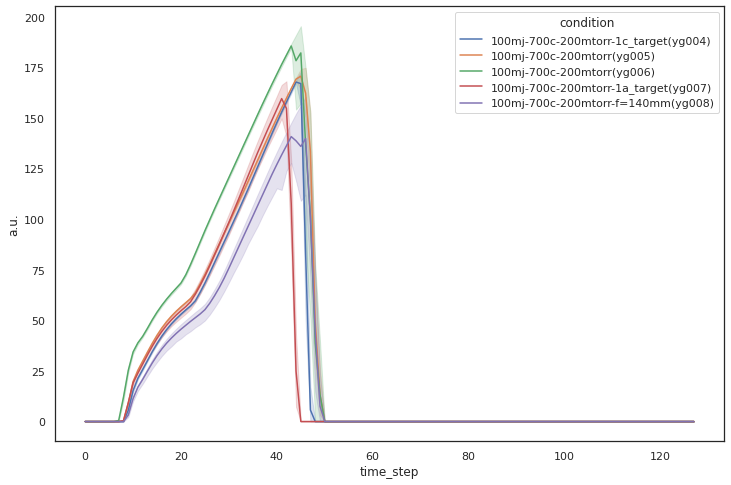

orientation


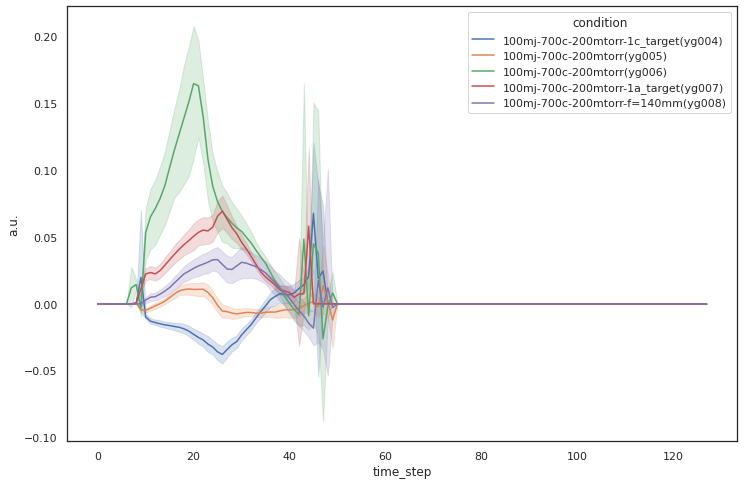

eccentricity


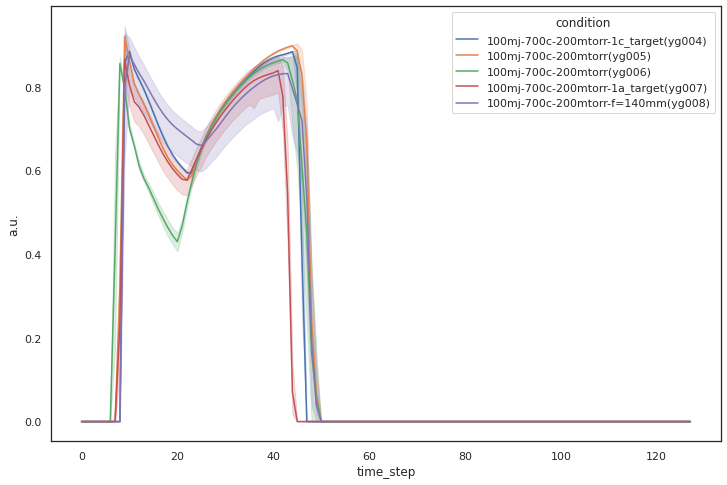

perimeter


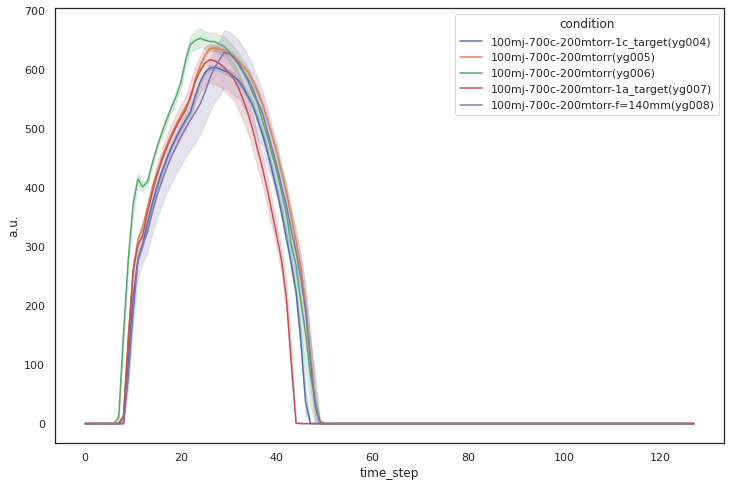

velocity


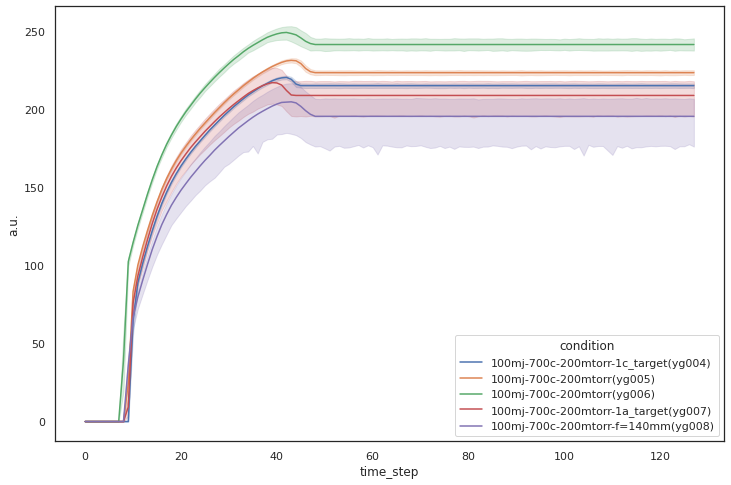

In [24]:
metrics_name = ['area', 'area_filled', 'axis_major_length', 
                'axis_minor_length', 'centroid-1', 'centroid-2', 'orientation', 
                'eccentricity', 'perimeter', 'velocity'] 

for metric in metrics_name:
    print(metric)
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")

    plot = sns.lineplot(data=df_t_s[df_t_s['metric']==metric], 
                        x='time_step', y='a.u.', hue='condition')
    plt.show()

# temerature

In [25]:
df_t = pd.concat([df_yg006_3, df_yg006_4, df_yg006_5], ignore_index=True)

area


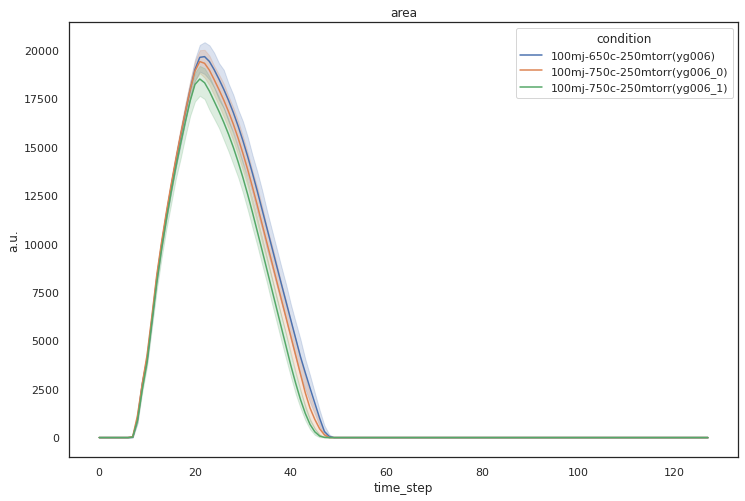

area_filled


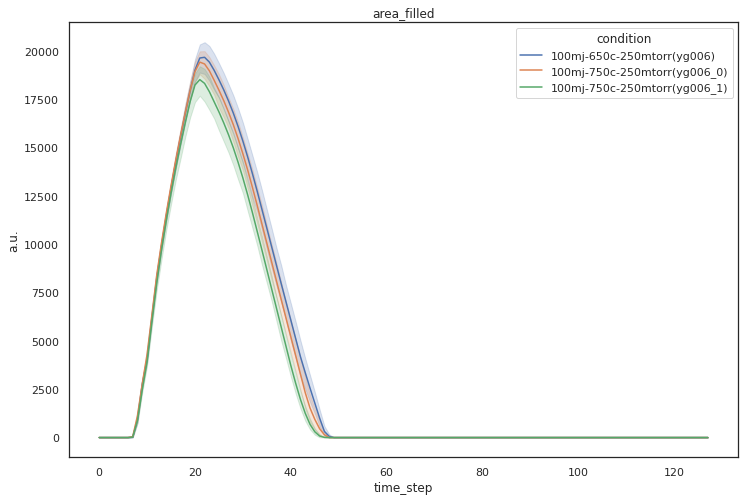

axis_major_length


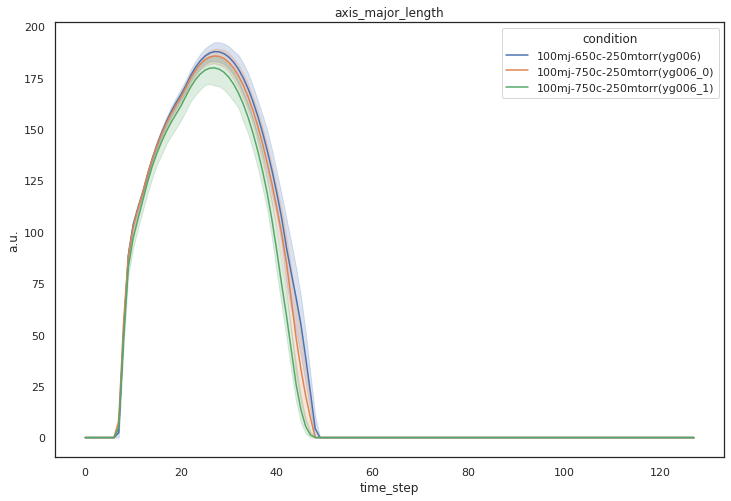

axis_minor_length


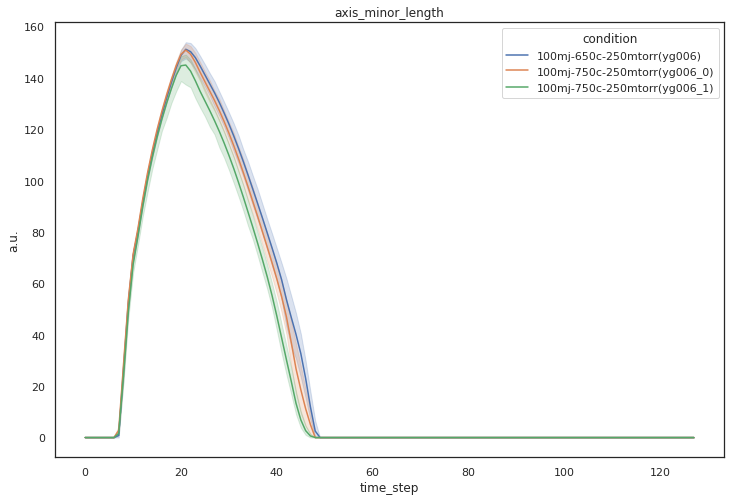

centroid-1


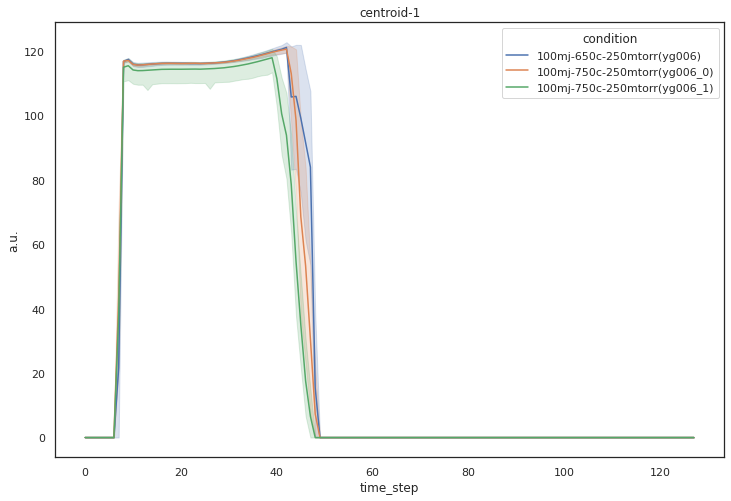

centroid-2


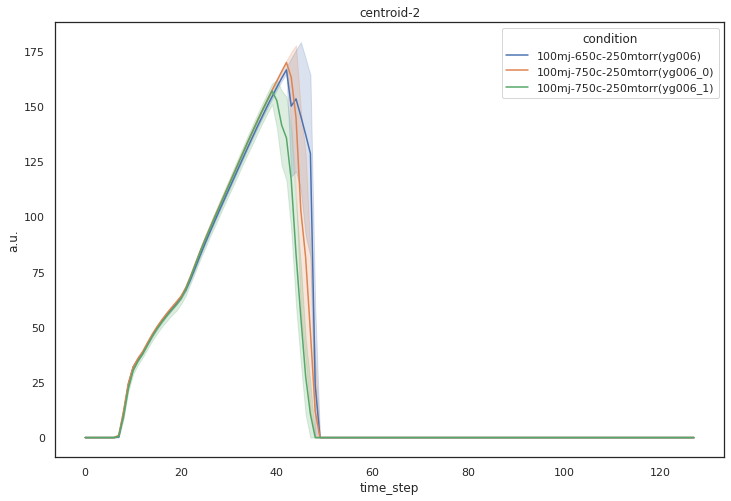

orientation


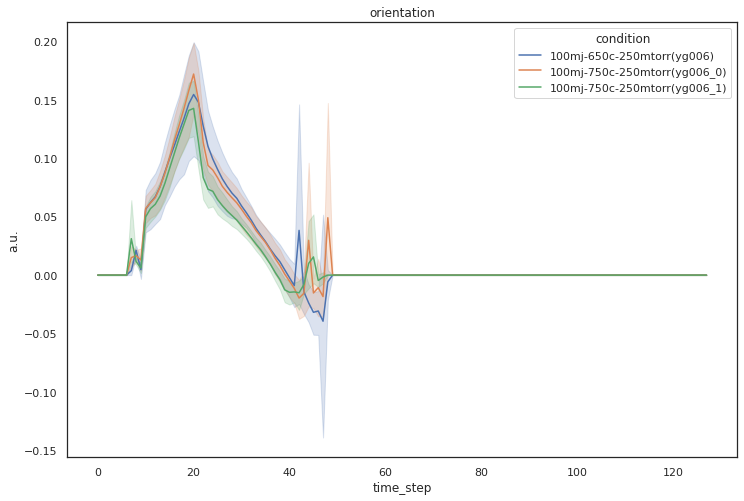

eccentricity


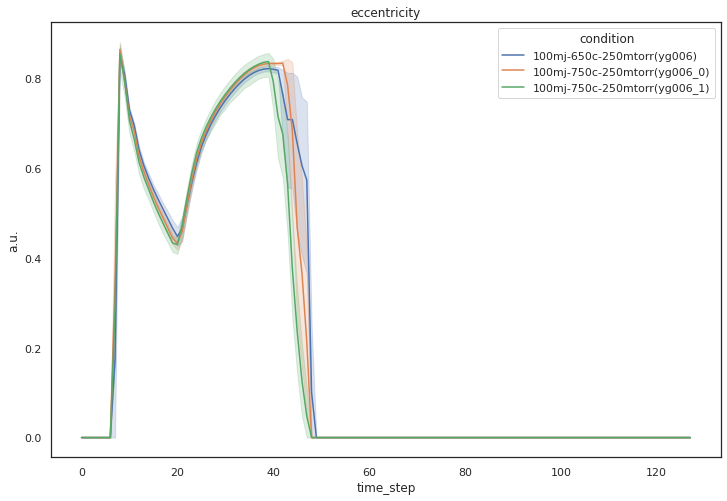

perimeter


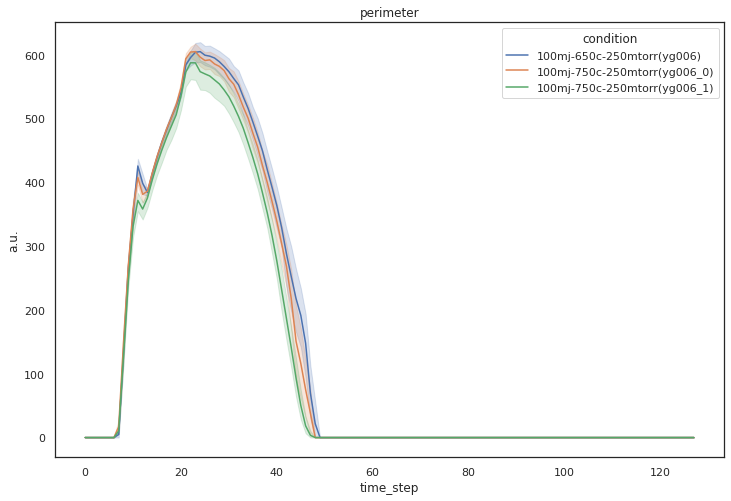

velocity


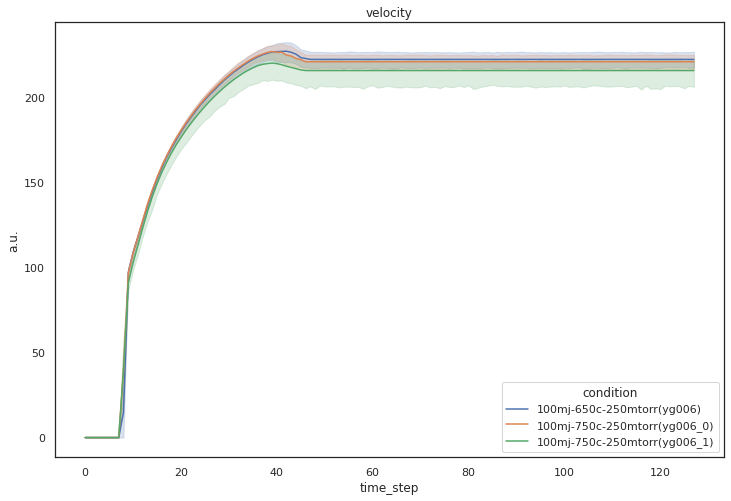

In [26]:
metrics_name = ['area', 'area_filled', 'axis_major_length', 
                'axis_minor_length', 'centroid-1', 'centroid-2', 'orientation', 
                'eccentricity', 'perimeter', 'velocity'] 

for metric in metrics_name:
    print(metric)
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")

    plot = sns.lineplot(data=df_t[df_t['metric']==metric], 
                        x='time_step', y='a.u.', hue='condition')
    plt.title(metric)
    plt.show()

# pressure

In [31]:
df_p = pd.concat([df_yg006_1, df_yg006_0, df_yg006_2], ignore_index=True)

area


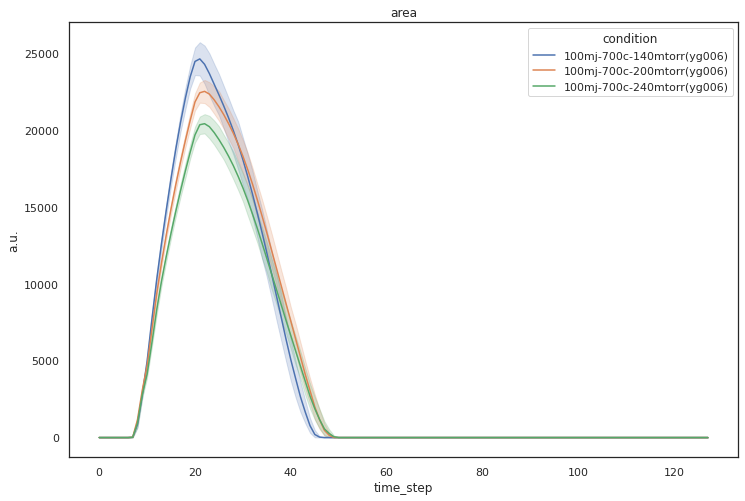

area_filled


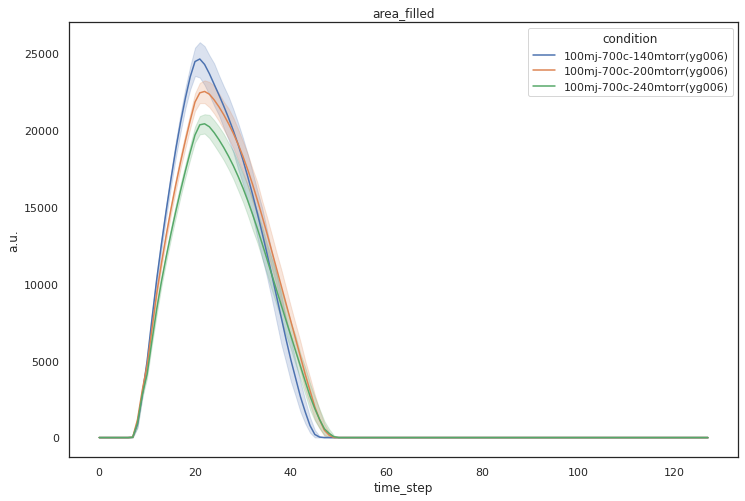

axis_major_length


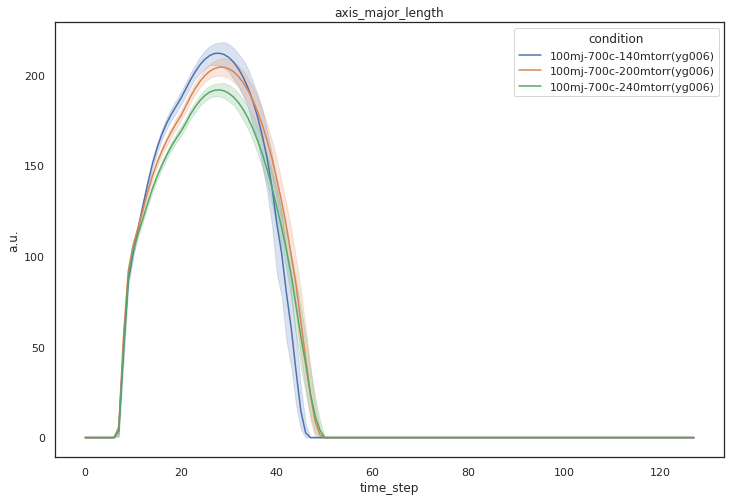

axis_minor_length


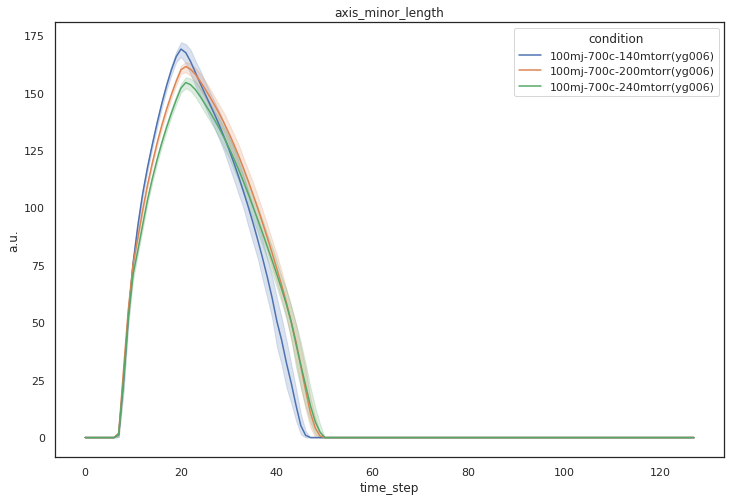

centroid-1


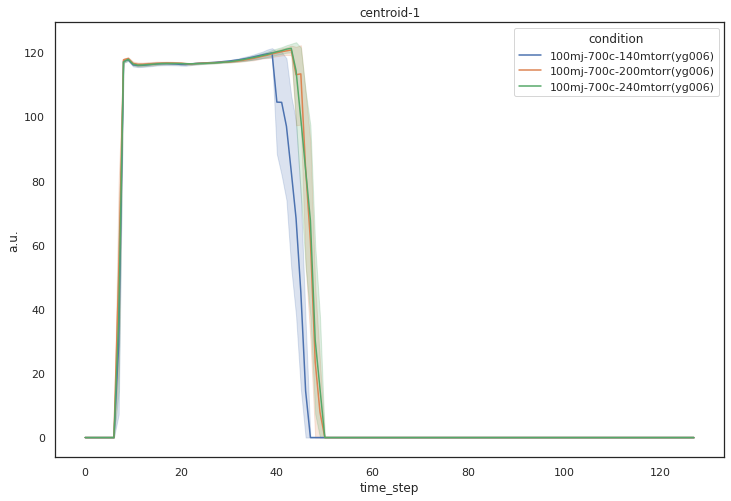

centroid-2


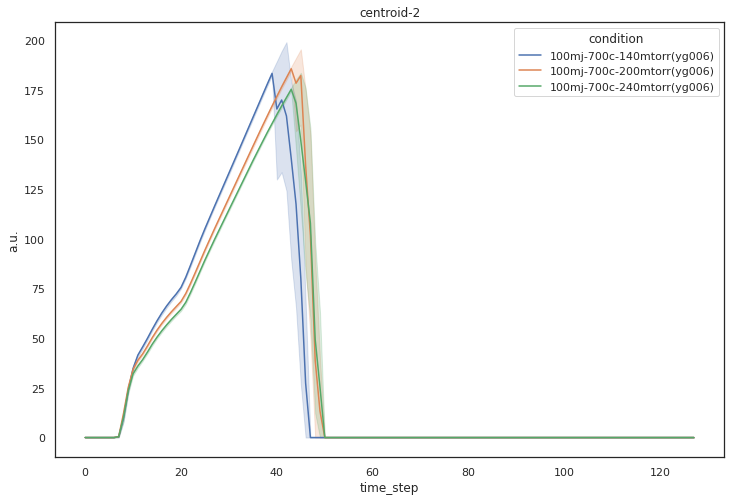

orientation


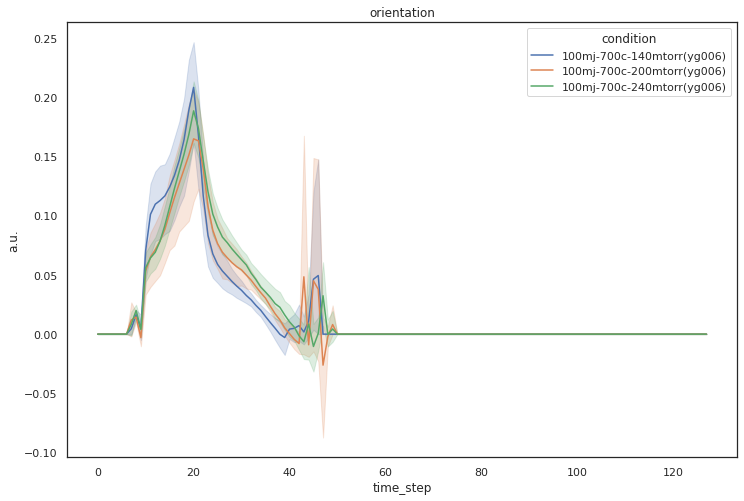

eccentricity


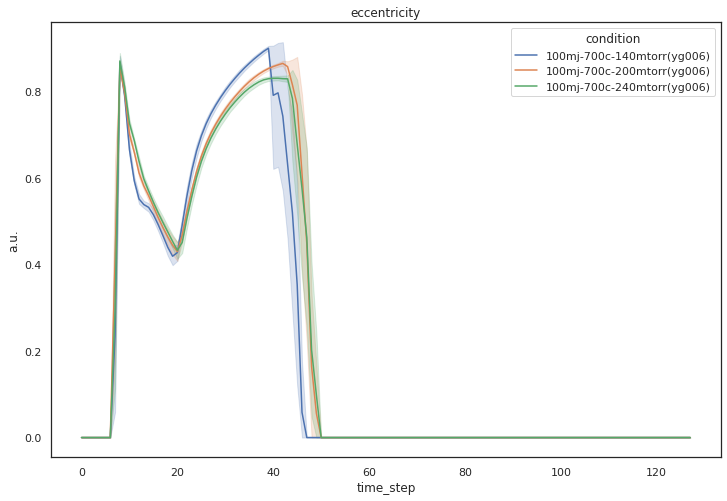

perimeter


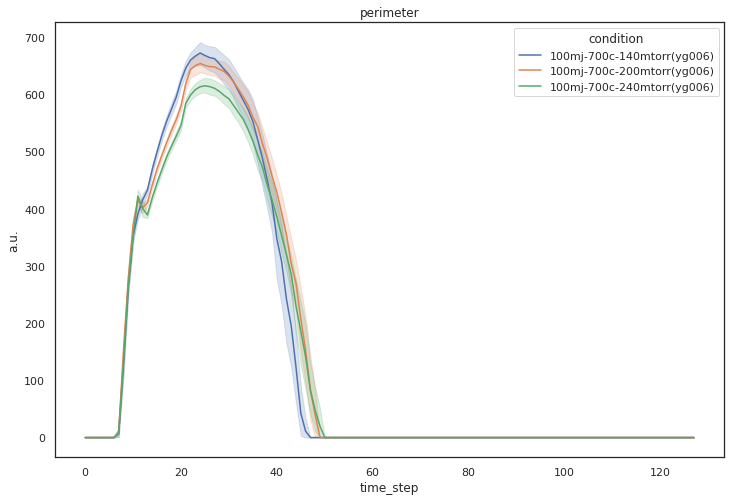

velocity


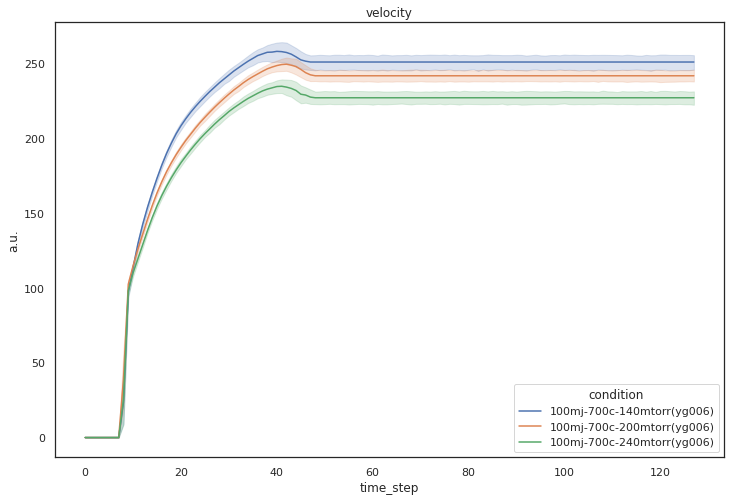

In [32]:
metrics_name = ['area', 'area_filled', 'axis_major_length', 
                'axis_minor_length', 'centroid-1', 'centroid-2', 'orientation', 
                'eccentricity', 'perimeter', 'velocity'] 

for metric in metrics_name:
    print(metric)
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")

    plot = sns.lineplot(data=df_p[df_p['metric']==metric], 
                        x='time_step', y='a.u.', hue='condition')
    plt.title(metric)
    plt.show()

# focus

In [29]:
df_f = pd.concat([df_yg008_0, df_yg008_1, df_yg008_2, 
                  df_yg008_3, df_yg008_4], ignore_index=True)

area


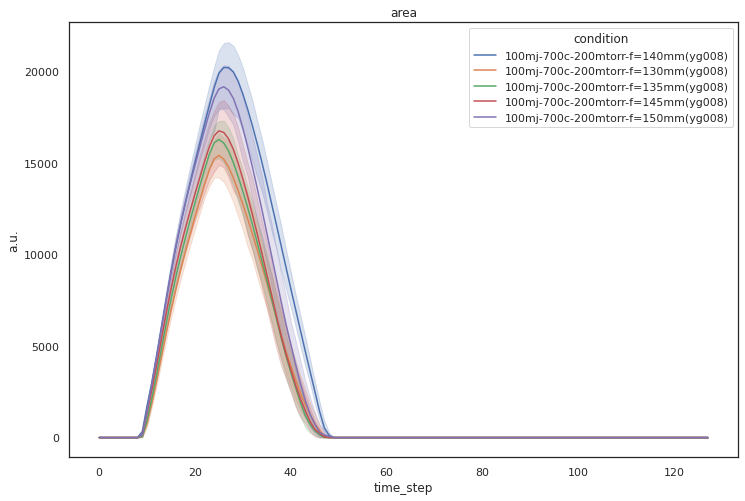

area_filled


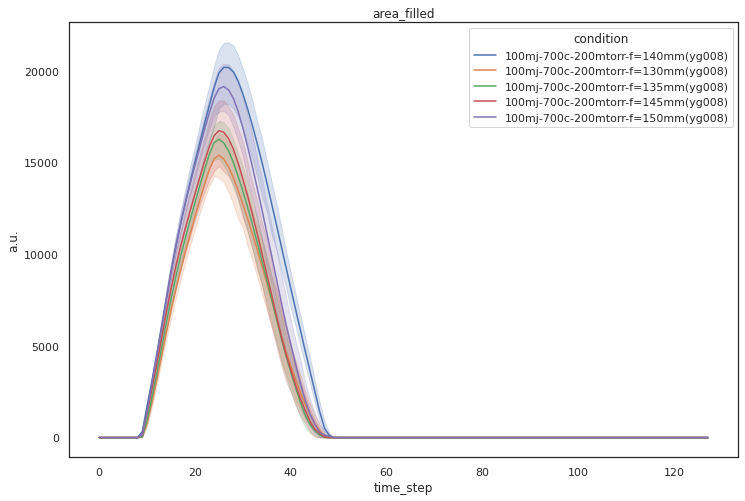

axis_major_length


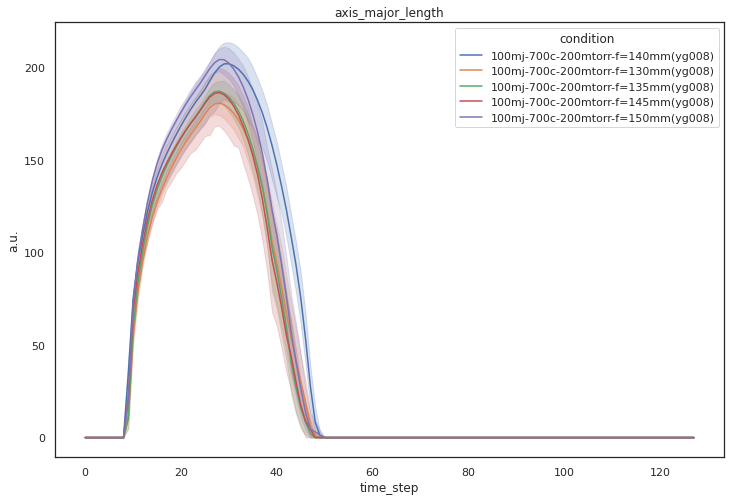

axis_minor_length


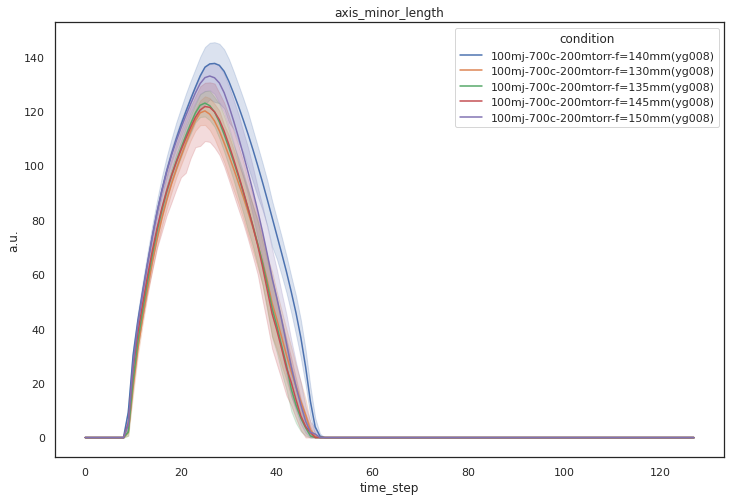

centroid-1


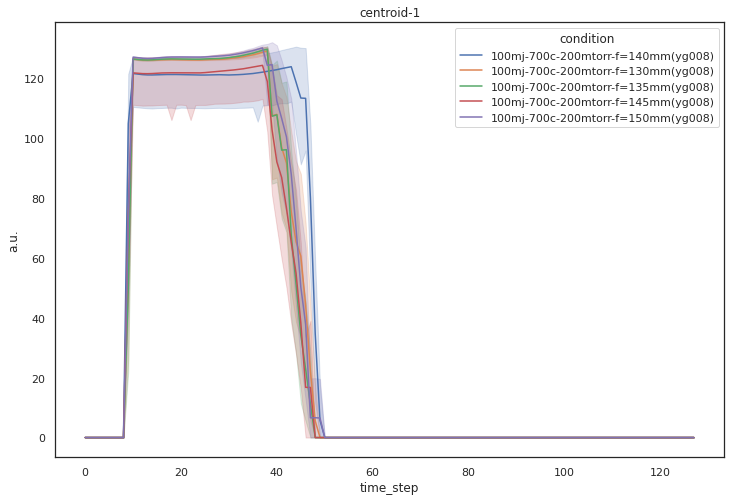

centroid-2


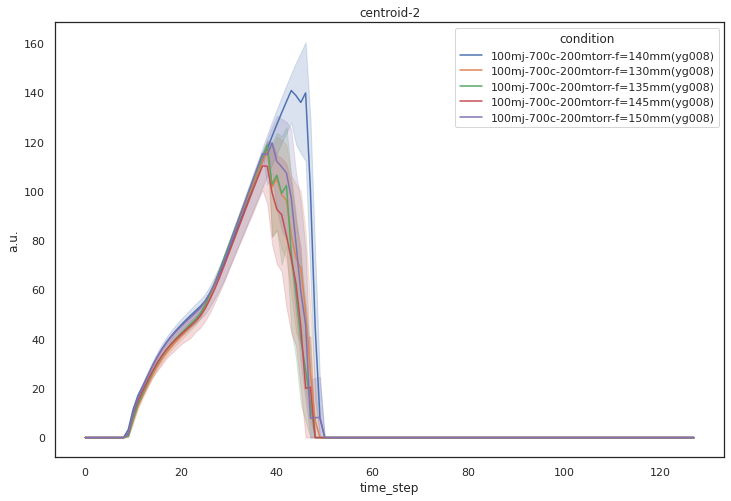

orientation


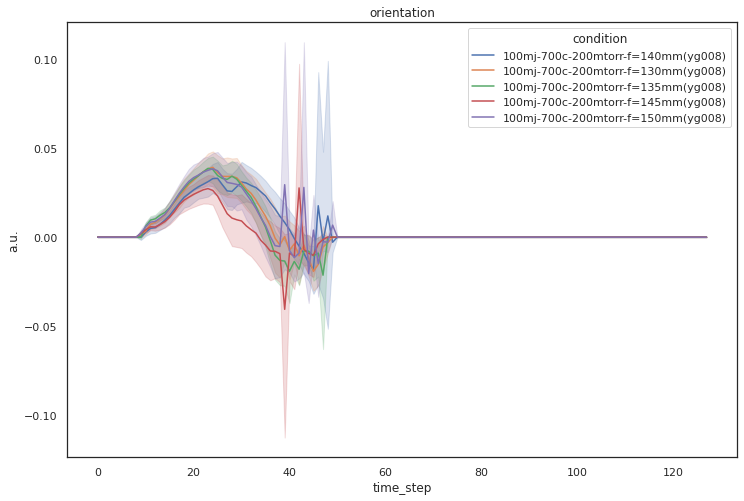

eccentricity


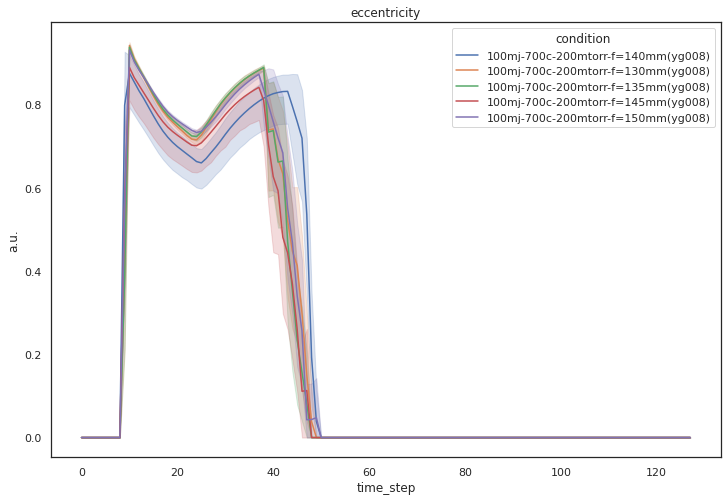

perimeter


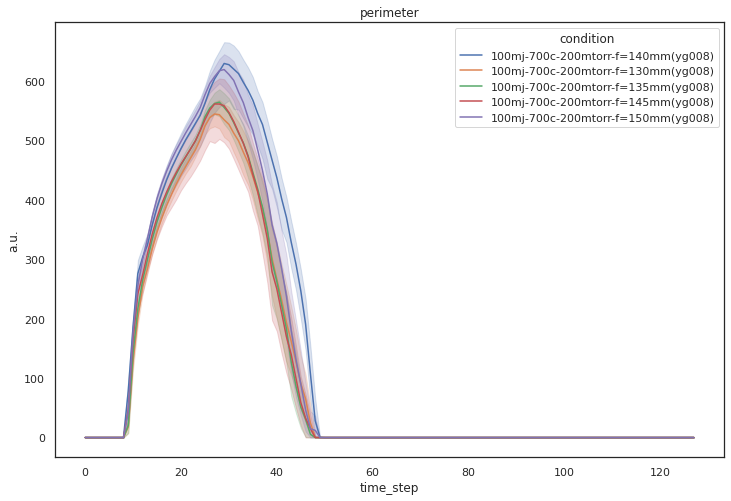

velocity


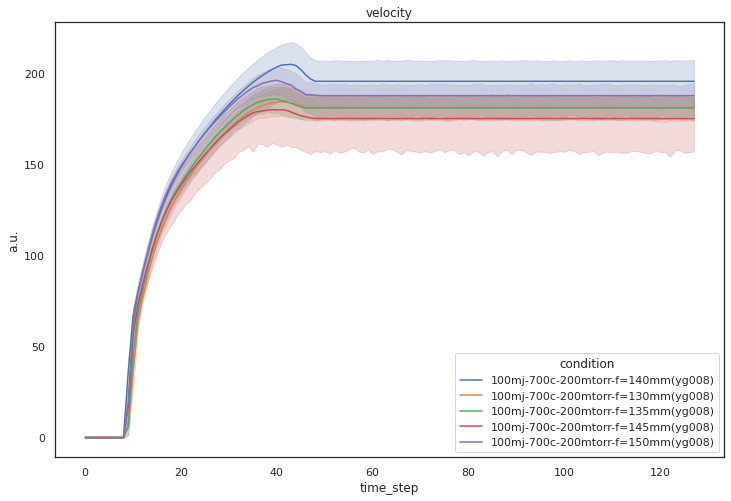

In [30]:
metrics_name = ['area', 'area_filled', 'axis_major_length', 
                'axis_minor_length', 'centroid-1', 'centroid-2', 'orientation', 
                'eccentricity', 'perimeter', 'velocity'] 

for metric in metrics_name:
    print(metric)
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")

    plot = sns.lineplot(data=df_f[df_f['metric']==metric], 
                        x='time_step', y='a.u.', hue='condition')
    plt.title(metric)
    plt.show()